## Scrapping

En primer lugar comenzamos definiendo el objeto reddit, y realizamos una serie de pruebas para empezar a scrappear la informacion de reddit.

In [2]:
from time import sleep

In [3]:
import praw

# Configura tu conexión con Reddit
reddit = praw.Reddit(
    client_id="XEVqTpGA9HE6MNujQAWt1w",
    client_secret="bv4J3usOH-V__I4tGD__bLoWnGA_Sg",
    user_agent="Testing_api",
    read_only=True
)



ModuleNotFoundError: No module named 'praw'

Vamos a comenzar a buscar en el subreddit de la tierra plana, y ver si podemos realizar una consulta simple.


In [ ]:
# Define el subreddit y la búsqueda
subreddit_name = "flatearth"

queries_list = [
    "flat earth",
]

resultados_totales = set()

subredit = reddit.subreddit(subreddit_name)

# Realiza la búsqueda en el subreddit
for query in queries_list:
    print(f"Buscando en el subreddit {subreddit_name} con la consulta '{query}'")
    resultados = subredit.search(query, limit=100)
    
    # Itera sobre los resultados
    for submission in resultados:
        # Verifica si el título ya está en los resultados totales
        if submission.title not in resultados_totales:
            resultados_totales.add(submission)

Buscando en el subreddit flatearth con la consulta 'flat earth'


Una vez realizamos la consulta, vemos la información que tenemos de cada post para ver cómo relacionar los nodos y estructurar el grafo.

In [ ]:
#Tomamos el primer post de los resultados

post = list(resultados_totales)[0]

In [ ]:
# Extraer el título y el contenido del post asi como el nombre del autor

print(f"Title: {post.title}")
print(f"Author: {post.author}")
print(f"Content: {post.selftext}")
print(f"URL: {post.url}")
print(f"Upvotes: {post.ups}")
print(f"Downvotes: {post.downs}")
print(f"Comments: {post.num_comments}")
print(f"Created: {post.created}")
print(f"Subreddit: {post.subreddit}")
print(f"Post ID: {post.id}")
print(f"Post URL: {post.url}")
print(f"Post Score: {post.score}")

print('\n\n')

#Navegar el arbol de comentarios
comentarios = post.comments

comentario = comentarios[0]
print(f"Comentario: {comentario.body}")
print(f"Autor: {comentario.author}")
print(f"Upvotes: {comentario.ups}")
print(f"Downvotes: {comentario.downs}")
print(f"Created: {comentario.created}")
print(f"Comentario ID: {comentario.id}")
print(f"Comentario URL: {comentario.permalink}")
print(f"Comentario Score: {comentario.score}")

Title: Research “flat earth” 
Author: Lorenofing
Content: 
URL: https://i.redd.it/30o3wt2mr9bd1.jpeg
Upvotes: 230
Downvotes: 0
Comments: 140
Created: 1720433338.0
Subreddit: flatearth
Post ID: 1dy58jz
Post URL: https://i.redd.it/30o3wt2mr9bd1.jpeg
Post Score: 230



Comentario: It definitely works as a coaster/beermat. I want one.
Autor: CoolNotice881
Upvotes: 47
Downvotes: 0
Created: 1720435000.0
Comentario ID: lc68akj
Comentario URL: /r/flatearth/comments/1dy58jz/research_flat_earth/lc68akj/
Comentario Score: 47


### Extracción de publicaciones y comentarios desde la API de Reddit

Al consultar la API obtenemos, en un solo lote, toda la información de cada publicación y de sus comentarios: incluso los “hilos” anidados aparecen aplanados en una lista única, lo que facilita procesarlos sin navegar por una estructura de árbol.

---

#### Limitaciones y retos

1. **Máximo de 100 publicaciones por consulta**  
   La API solo devuelve hasta 100 posts en cada llamada. Si necesitamos más, debemos encadenar varias consultas y combinar sus resultados manualmente.

2. **Límite de peticiones por segundo**  
   Reddit restringe la frecuencia de llamadas: demasiadas peticiones en corto tiempo pueden provocar bloqueos temporales. Es imprescindible espaciar las consultas (por ejemplo, con `time.sleep()`) o gestionar un backoff automático.

3. **Posibles duplicados**  
   Al hacer varias consultas (por fecha, por palabra clave, etc.), podemos recuperar el mismo post varias veces. Hay que implementar un filtro que descarte identificadores repetidos.

4. **Ruido y contenido irrelevante**  
   Memes, publicaciones bromistas o comentarios sin sustancia pueden contaminar el análisis. Para centrarnos en usuarios realmente convencidos, es útil definir términos clave o patrones de búsqueda que apunten a debates serios.

---

#### Estrategia sugerida

Una manera eficaz de sortear estas limitaciones es:

1. **Definir una lista de palabras clave**  
   Representativas del tema (p. ej. “terrabrain”, “climate hoax”, “antivax”).

2. **Ejecutar una consulta por cada término**  
   Recuperando hasta 100 posts en cada ronda.

3. **Unir todos los resultados**  
   En una sola colección, eliminando duplicados por ID.

4. **Aplicar un pequeño retardo**  
   Entre peticiones para respetar el límite de la API.

5. **Filtrar el contenido final**  
   - Buscar solo publicaciones que contengan varias de esas palabras clave.  
   - O bien establecer un umbral mínimo de upvotes, para quedarnos con interacciones de mayor relevancia.

De este modo, ampliamos la cobertura más allá de 100 posts, reducimos el ruido y evitamos bloqueos por exceso de llamadas.


In [ ]:
%pip install networkx matplotlib.pyplot tqdm

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm


#### Definición de funciones para extraer datos de Reddit y construir el grafo

Vamos a definir una serie de funciones que nos permitan:

1. Recuperar la información relevante desde la API de Reddit (publicaciones, comentarios, autores, etc.).  
2. Procesar esos datos para identificar entidades (usuarios, subreddits) y sus relaciones.  
3. Almacenar todo en un grafo utilizando la librería **networkx**, donde cada nodo representará un usuario o un subreddit y cada arista reflejará una interacción.


In [ ]:
def get_results(subreddit, query_list, n_post = 10):
    resultados_totales = set()
    
    subredit = reddit.subreddit(subreddit)
    
    for query in query_list:
        print(f"Buscando en el subreddit {subreddit} con la consulta '{query}'")
        
        try:
        
            resultados = subredit.search(query, limit=n_post)
            
            for submission in resultados:
                # Verifica si el título ya está en los resultados totales
                if submission.title not in resultados_totales:
                    resultados_totales.add(submission)
                    
        except Exception:
            continue
                
    return resultados_totales


##### Función `scrapear_subreddit`

Esta función extrae información de un subreddit y la convierte en un grafo de interacciones entre usuarios y el propio subreddit.

1. **Obtener posts**  
   Llama a `get_results(subreddit, query_list, n_post)` para recuperar hasta `n_post` publicaciones que coincidan con las palabras clave de `query_list`.

2. **Crear nodo de subreddit**  
   Añade el nombre del subreddit como **nodo raíz** en el grafo.

3. **Procesar cada publicación**  
   Para cada `post` obtenido:
   - Si existe autor, lo añade como nodo y crea una arista entre el subreddit y el autor.
   - Descarga **todos** los comentarios (gestionando posibles errores de rate limit).
   - Ordena los comentarios por `score` (de mayor a menor).
   - Si se especifica `max_comments`, recorta la lista a ese número.

4. **Construir conexiones entre usuarios**  
   Para cada comentario seleccionado:
   - Añade al autor del comentario como nodo (si no estaba).
   - Crea una arista **directa** entre el autor del post y el autor del comentario (sin duplicados).

---

**Resumen:**  
`scapear_subreddit` construye un grafo donde:
- **Nodos** = subreddits y usuarios.  
- **Aristas** = interacción (quién publica en qué subreddit, quién comenta los posts de quién).  
Esto permite visualizar y analizar la red de conversaciones dentro de un subreddit.  



In [ ]:
def scrapear_subreddit(subreddit, query_list, n_post = 10, max_comments = None):
    
    # Obtener los resultados
    resultados_totales = get_results(subreddit, query_list, n_post)

    # Agregar nodo raíz al grafo
    grafo.add_node(subreddit)
    
    # Agregar los nodos y aristas al grafo
    for post in tqdm(list(resultados_totales)):
        if post.author:
            grafo.add_node(post.author.name,subreddit=subreddit)
            grafo.add_edge(subreddit, post.author.name)
            
        while True:
            try:
                post.comments.replace_more(limit=None)
                break
            except Exception:
                print('demasiadas peticiones')
                sleep(10)
            
        comentarios = sorted(post.comments.list(), key=lambda x: x.score, reverse=True)
        
        for comentario in comentarios:
            if comentario.author:
                #comprueba que el nodo ya existe
                if grafo.has_node(comentario.author.name):
                    if not grafo.has_edge(post.author.name, comentario.author.name):
                        grafo.add_edge(post.author.name, comentario.author.name)
                        
        if max_comments is not None:
            comentarios = comentarios[:max_comments]
        
        for comentario in comentarios:
            if comentario.author:
                grafo.add_node(comentario.author.name, subreddit=subreddit)
                #comprobar que no exista ya la arista
                if not grafo.has_edge(post.author.name, comentario.author.name):
                    grafo.add_edge(post.author.name, comentario.author.name)

De esta forma podemos tomar información de un subreddit en función de las palabras clave de la lista, guardándolas en un grafo después.

In [ ]:
# Probamos entonces nuestra funcion de scrapping.
grafo = nx.Graph()

scrapear_subreddit('flatearth', ['flatearth'], n_post = 10)
scrapear_subreddit('antivaccine', ['antivaccine'], n_post = 10)


Buscando en el subreddit flatearth con la consulta 'flatearth'


 10%|█         | 1/10 [00:06<01:01,  6.83s/it]


KeyboardInterrupt: 

Numero de nodos: 1553
Numero de aristas: 1654
Numero de componentes: 2
Promedio de grado: 2.130070830650354
Promedio de clustering: 0.0020872147617880593


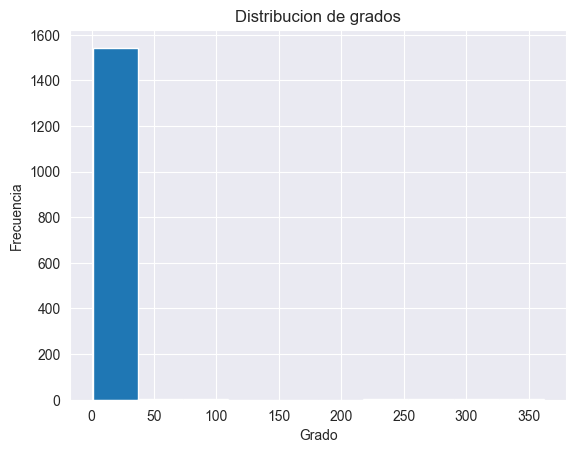

In [ ]:
# Vamos a ver algunas de las características del grafo

print(f"Numero de nodos: {grafo.number_of_nodes()}")
print(f"Numero de aristas: {grafo.number_of_edges()}")
print(f"Numero de componentes: {nx.number_connected_components(grafo)}")
print(f"Promedio de grado: {sum(dict(grafo.degree()).values())/grafo.number_of_nodes()}")
print(f"Promedio de clustering: {nx.average_clustering(grafo)}")

# Y un histograma de la distribucion de grados

plt.hist([grafo.degree(nodo) for nodo in grafo.nodes()])
plt.xlabel('Grado')
plt.ylabel('Frecuencia')
plt.title('Distribucion de grados')
plt.show()


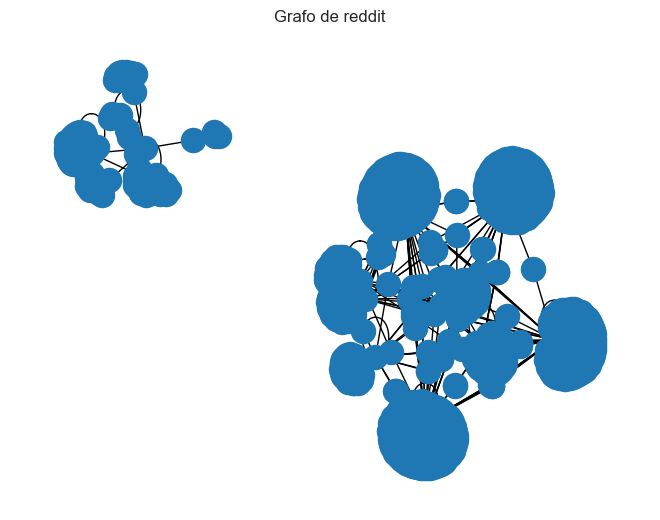

In [ ]:
# Vamos a ver el grafo

nx.draw(grafo)
plt.title('Grafo de reddit')
plt.show()

In [ ]:
#exporta el grafo a un archivo GML

nx.write_gml(grafo, "grafo.gml")

#### Preparando las queries para el grafo definitivo.

Buscamos los subreddit que nos puedan ayudar a resolver nuestra hipótesis, además de palabras clave que diferencien a los usuarios creyentes de los que no lo son.

In [ ]:
lista_comunes = ["critical thinking", "question everything", "pseudoscience",  "debunk", "denial", "conspiracy"]

subreddit_keywords = {
    'FlatEarth': [
        'flat earth theory',
        'ice wall discovery',
        'antarctic cover‑up',
        'horizon anomaly',
        'ground is level',
        *lista_comunes
    ],
    'moonlandinghoax': [
        'fake lunar mission',
        'studio filmed moon',
        'camera glitch proof',
        'lunar module lies',
        'NASA backlot conspiracy',
        *lista_comunes
    ],
    'aliens': [
        'ufo disclosure',
        'area 51 secrets',
        'extraterrestrial visit',
        'crop circle proof',
        'alien cover‑up',
        *lista_comunes
    ],
    'No5G': [
        '5g health risks',
        'radiation cover‑up',
        'cell tower danger',
        'electromagnetic fraud',
        'hidden toxicity',
        *lista_comunes
    ],
    'chemtrails': [
        'chemical spraying',
        'aerosol cover‑up',
        'geoengineering proof',
        'toxics in sky',
        'secret air program',
        *lista_comunes
    ],
    'antiVaxx': [
        'big pharma lies',
        'vaccine injury cover‑up',
        'unreported side effects',
        'injection fraud',
        'medical experimentation',
        *lista_comunes
    ],
    'pesticideconspiracy': [
        'pesticide runoff cover‑up',
        'agrochemical conspiracy',
        'glyphosate danger',
        'farmers whistleblower',
        'toxic crop spraying',
        *lista_comunes
    ],
    'CovidConspiracy': [
        'plandemic proof',
        'virus lab leak cover‑up',
        'mask mandate fraud',
        'PCR gate',
        'vaccine passport tyranny',
        *lista_comunes
    ],
    'climatechangeisalie': [
        'co2 myth',
        'green agenda',
        'warming scam',
        'carbon tax cover‑up',
        'environment fraud',
        *lista_comunes
    ],
    'newworldorder': [
        'one world government',
        'global elite plan',
        'shadow government proof',
        'population control agenda',
        'nwo conspiracy',
        *lista_comunes
    ],
    
    'SimulationTheory': [
        'we live in a simulation',
        'matrix is real',
        'simulated reality proof',
        'glitch in the matrix',
        'reality is fake',
        'computer-generated universe',
        'consciousness and simulation',
        'base reality hypothesis',
        'elon musk simulation',
        'philosophical zombies',
        *lista_comunes
    ],
    'Plandemic': [
        'covid was planned',
        'virus patent evidence',
        'event 201 proof',
        'pandemic simulation cover-up',
        'vaccine agenda',
        'plandemic documentary',
        'mass control operation',
        'false positive PCR',
        'big pharma profits',
        'government fear propaganda',
        *lista_comunes
    ],
    'DebateHolocaust': [
        'holocaust exaggeration claims',
        'gas chamber doubts',
        'revisionist history',
        'ww2 narrative question',
        'auschwitz controversy',
        'truth about holocaust',
        'holocaust denial arguments',
        'zionist agenda claims',
        'nuremberg trials critique',
        'forbidden historical facts',
        *lista_comunes
    ],
    'Epstein': [
        'epstein didn’t kill himself',
        'epstein client list',
        'ghislaine maxwell secrets',
        'elite pedophile ring',
        'epstein island evidence',
        'blackmail operation',
        'intelligence agency ties',
        'jeffrey epstein cover‑up',
        'flight logs secrets',
        'missing surveillance tapes',
        *lista_comunes
    ]
}

De nuevo, realizamos scraping y guardamos en el grafo que analizaremos.

In [ ]:
#crea un grafo vacio
grafo = nx.Graph()

for subreddit, queries in subreddit_keywords.items():
    scrapear_subreddit(subreddit, queries, n_post = 10)

# Exporta el grafo a un archivo GML
nx.write_gml(grafo, "grafo.gml")

#### Analizando el grafo

Vemos qué información de utilidad podemos obtener del grafo generado.

In [ ]:
# Cargar el grafo desde el archivo GML
grafo = nx.read_gml("grafo.gml")

In [ ]:
# Vamos a ver algunas de las características del grafo

print(f"Numero de nodos: {grafo.number_of_nodes()}")
print(f"Numero de aristas: {grafo.number_of_edges()}")
print(f"Numero de componentes: {nx.number_connected_components(grafo)}. Una posible causa es la de un scraping defectuoso en alguna de las conspiraciones, ya que a simple vista tenemos un grafo bastante conectado.")
print(f"Grado promedio (usuarios con los que interactúa cada nodo): {sum(dict(grafo.degree()).values())/grafo.number_of_nodes()}")
print(f"Promedio de clustering (cuán densa es la red): {nx.average_clustering(grafo)}")

NameError: name 'grafo' is not defined

In [ ]:
# vamos a calcular los nodos mas importantes del grafo, y ver si podemos encontrar comunidades dentro del grafo

# Calcula el PageRank
pagerank = nx.pagerank(grafo)
# Ordena los nodos por PageRank
sorted_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)
print("Top 10 nodos por PageRank:")
for nodo, score in sorted_pagerank[:10]:
    print(f"{nodo}: {score}")
    

vamos a hacer una grafica que combine los histogramas de los diferentes subgrafos en funcion de su subreddit. Para estudiar que subreddits son mas virales que el resto, y cuales tienen mas interacciones.

In [ ]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import community as community_louvain  # python-louvain
import random

# --- 1. CARGA DEL GRAFO ---
G = grafo

A continuación presentamos la distribución de los grados de la red, donde se aprecia una concentración en los grados bajos, llegando hastas nodos con más de 1000 usuarios conectados, los que podríamos llamar superactivos.

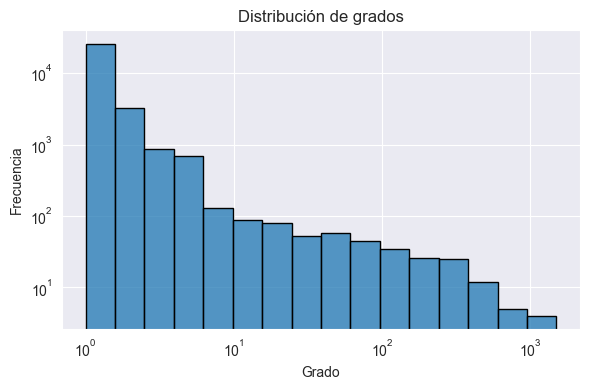

In [ ]:
degrees = [d for _, d in G.degree()]
plt.figure(figsize=(6,4))
sns.histplot(degrees, kde=False, edgecolor='black', log_scale=True)
plt.xscale('log')
plt.yscale('log')
plt.xticks([1, 10, 100, 1000])
plt.title("Distribución de grados")
plt.xlabel("Grado")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

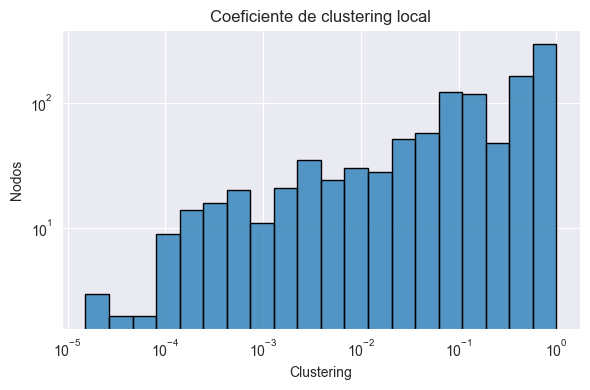

Clustering medio: 0.0124


In [ ]:
# --- 4. CLUSTERING LOCAL ---
clust_coef = nx.clustering(G)
df_clust = pd.Series(clust_coef, name='clustering')
plt.figure(figsize=(6,4))
sns.histplot(df_clust, kde=False, edgecolor='black', log_scale=True)
plt.xscale('log')
plt.yscale('log')
plt.title("Coeficiente de clustering local")
plt.xlabel("Clustering")
plt.ylabel("Nodos")
plt.tight_layout()
plt.show()

print(f"Clustering medio: {df_clust.mean():.4f}")

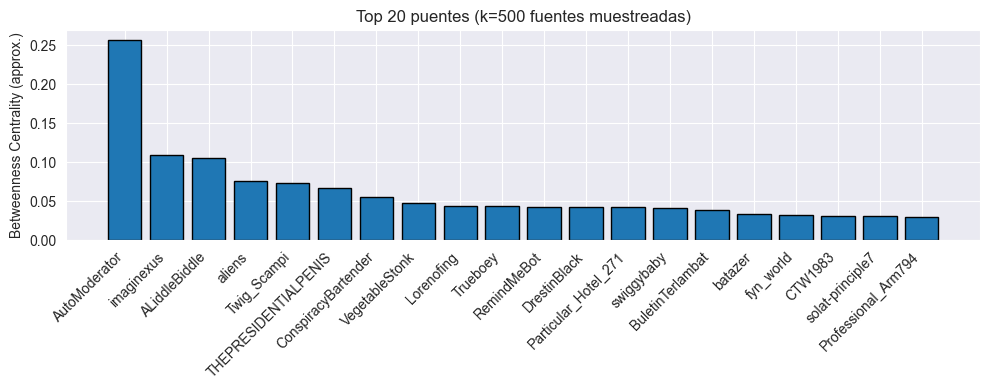

In [ ]:
if not nx.is_connected(G):
    cc = max(nx.connected_components(G), key=len)
    G = G.subgraph(cc).copy()


n = G.number_of_nodes()

k = min(500, n)
random.seed(42) 
bc = nx.betweenness_centrality(G, k=k, normalized=True, seed=42)

top20 = sorted(bc.items(), key=lambda x: x[1], reverse=True)[:20]
nodes, scores = zip(*top20)

plt.figure(figsize=(10,4))
plt.bar([str(u) for u in nodes], scores, edgecolor='black')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Betweenness Centrality (approx.)')
plt.title(f'Top 20 puentes (k={k} fuentes muestreadas)')
plt.tight_layout()
plt.show()

In [ ]:
# --- 6. EXCENTRICIDAD ---
ecc = nx.eccentricity(G0 if not nx.is_connected(G) else G)
df_ecc = pd.Series(ecc, name='excentricidad')
plt.figure(figsize=(6,4))
sns.histplot(df_ecc, bins=30, kde=False, edgecolor='black')
plt.title("Distribución de excentricidad")
plt.xlabel("Excentricidad")
plt.ylabel("Nodos")
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

In [ ]:
# --- 7. CLIQUES (opcional, si la red no es enorme) ---
cliques = list(nx.find_cliques(G))
print(f"Número total de cliques encontradas: {len(cliques)}")
max_clique_size = max(len(c) for c in cliques)
print(f"Tamaño de la clique máxima: {max_clique_size}")

In [ ]:
# --- 8. DETECCIÓN DE COMUNIDADES (Louvain) ---
partition = community_louvain.best_partition(G)
mod = community_louvain.modularity(partition, G)
print(f"Comunidades detectadas: {len(set(partition.values()))}")
print(f"Modularidad (Louvain): {mod:.3f}")

AttributeError: module 'community' has no attribute 'best_partition'

In [ ]:
# Histograma de tamaños de comunidad
com_sizes = pd.Series(list(partition.values())).value_counts()
plt.figure(figsize=(6,4))
sns.histplot(com_sizes, bins=30, kde=False, edgecolor='black')
plt.title("Tamaño de comunidades (Louvain)")
plt.xlabel("Número de nodos en comunidad")
plt.ylabel("Comunidades")
plt.tight_layout()
plt.show()

NameError: name 'partition' is not defined

In [ ]:

# --- 9. MODELO NULO ERDOS-RENYI ---
n, m = G.number_of_nodes(), G.number_of_edges()
G_rand = nx.gnm_random_graph(n, m, seed=42)
metrics_real = {
    'clustering': nx.average_clustering(G),
    'avg_path':   nx.average_shortest_path_length(G0),
    'diameter':   nx.diameter(G0)
}
# para la red aleatoria, mismo tratamiento
cc_r = max(nx.connected_components(G_rand), key=len)
G0_r = G_rand.subgraph(cc_r)
metrics_rand = {
    'clustering': nx.average_clustering(G_rand),
    'avg_path':   nx.average_shortest_path_length(G0_r),
    'diameter':   nx.diameter(G0_r)
}
print("\nComparativa Real vs Aleatoria:")
for k in metrics_real:
    print(f"{k:12s}  {metrics_real[k]:8.3f}   {metrics_rand[k]:8.3f}")

# --- FIN DEL ANÁLISIS ---

KeyboardInterrupt: 